## **Welcome to another "Playing with data" series**
The dataset used in this project will be the famous "boston house price" dataset while we will be going through 

Usually, standard ML pipeline starts with **understanding business problem**, **problem formulation (what do we need to predict?)** and **data collection**; however, we can skip these processes because we will be using a toy dataset, Boston.


[source](https://scikit-learn.org/stable/datasets/index.html)

# **About dataset**

**Features:**
- CRIM per capita crime rate by town
- ZN proportion of residential land zoned for lots over 25,000 sq.ft.
- INDUS proportion of non-retail business acres per town
- CHAS Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
- NOX nitric oxides concentration (parts per 10 million)
- RM average number of rooms per dwelling
- AGE proportion of owner-occupied units built prior to 1940
- DIS weighted distances to five Boston employment centres
- RAD index of accessibility to radial highways
- TAX full-value property-tax rate per 10,000 USD
- PTRATIO pupil-teacher ratio by town
- B 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
- LSTAT % lower status of the population

**Target:**
- MEDV Median value of owner-occupied homes in 1000 USD

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category=Warning)

In [ ]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.dummy import DummyRegressor
from sklearn import metrics

from xgboost import *

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

# **Load dataset**

In [ ]:
boston = load_boston()

In [ ]:
print(boston.data.shape)
print(boston.target.shape)

(506, 13)
(506,)


In [ ]:
# get feature names (X's and y)
feat_names = list(boston.feature_names)
feat_names.extend(['Target'])

data = pd.DataFrame(data = np.hstack((boston.data, boston.target[:, None])),
                    columns = feat_names)

In [ ]:
print(f"missing data: {data.any().isnull().sum()}")
print(f"duplicates  : {len(data) != len(data.drop_duplicates())}")

missing data: 0
duplicates  : False


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1],
                                                    data.iloc[:,-1],
                                                    test_size=0.20,
                                                    random_state=123)

In [ ]:
print(f"{X_train.shape}\n{X_test.shape}\n{y_train.shape}\n{y_test.shape}")

(404, 13)
(102, 13)
(404,)
(102,)


# **Exploratory Data Analysis**

In [ ]:
X_train.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,404.000000,404.000000,404.000000,404.000000,404.00000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.556133,11.163366,11.190347,0.056931,0.55548,6.281676,68.974505,3.786204,9.509901,408.445545,18.463861,357.209084,12.825347
std,8.788241,22.973132,6.949621,0.231997,0.11639,0.704875,28.021271,2.138012,8.661394,168.499919,2.148906,91.677481,7.127718
min,0.006320,0.000000,0.460000,0.000000,0.38500,3.561000,6.000000,1.169100,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.081960,0.000000,5.130000,0.000000,0.45200,5.887750,45.325000,2.097050,4.000000,279.000000,17.400000,376.092500,7.187500
50%,0.252775,0.000000,9.690000,0.000000,0.53800,6.201500,77.700000,3.100900,5.000000,330.000000,19.050000,391.955000,11.490000
75%,3.681942,12.500000,18.100000,0.000000,0.62400,6.616500,94.100000,5.117025,24.000000,666.000000,20.200000,396.157500,17.127500
max,88.976200,100.000000,27.740000,1.000000,0.87100,8.725000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,36.980000


### **Distributions and Correlations**

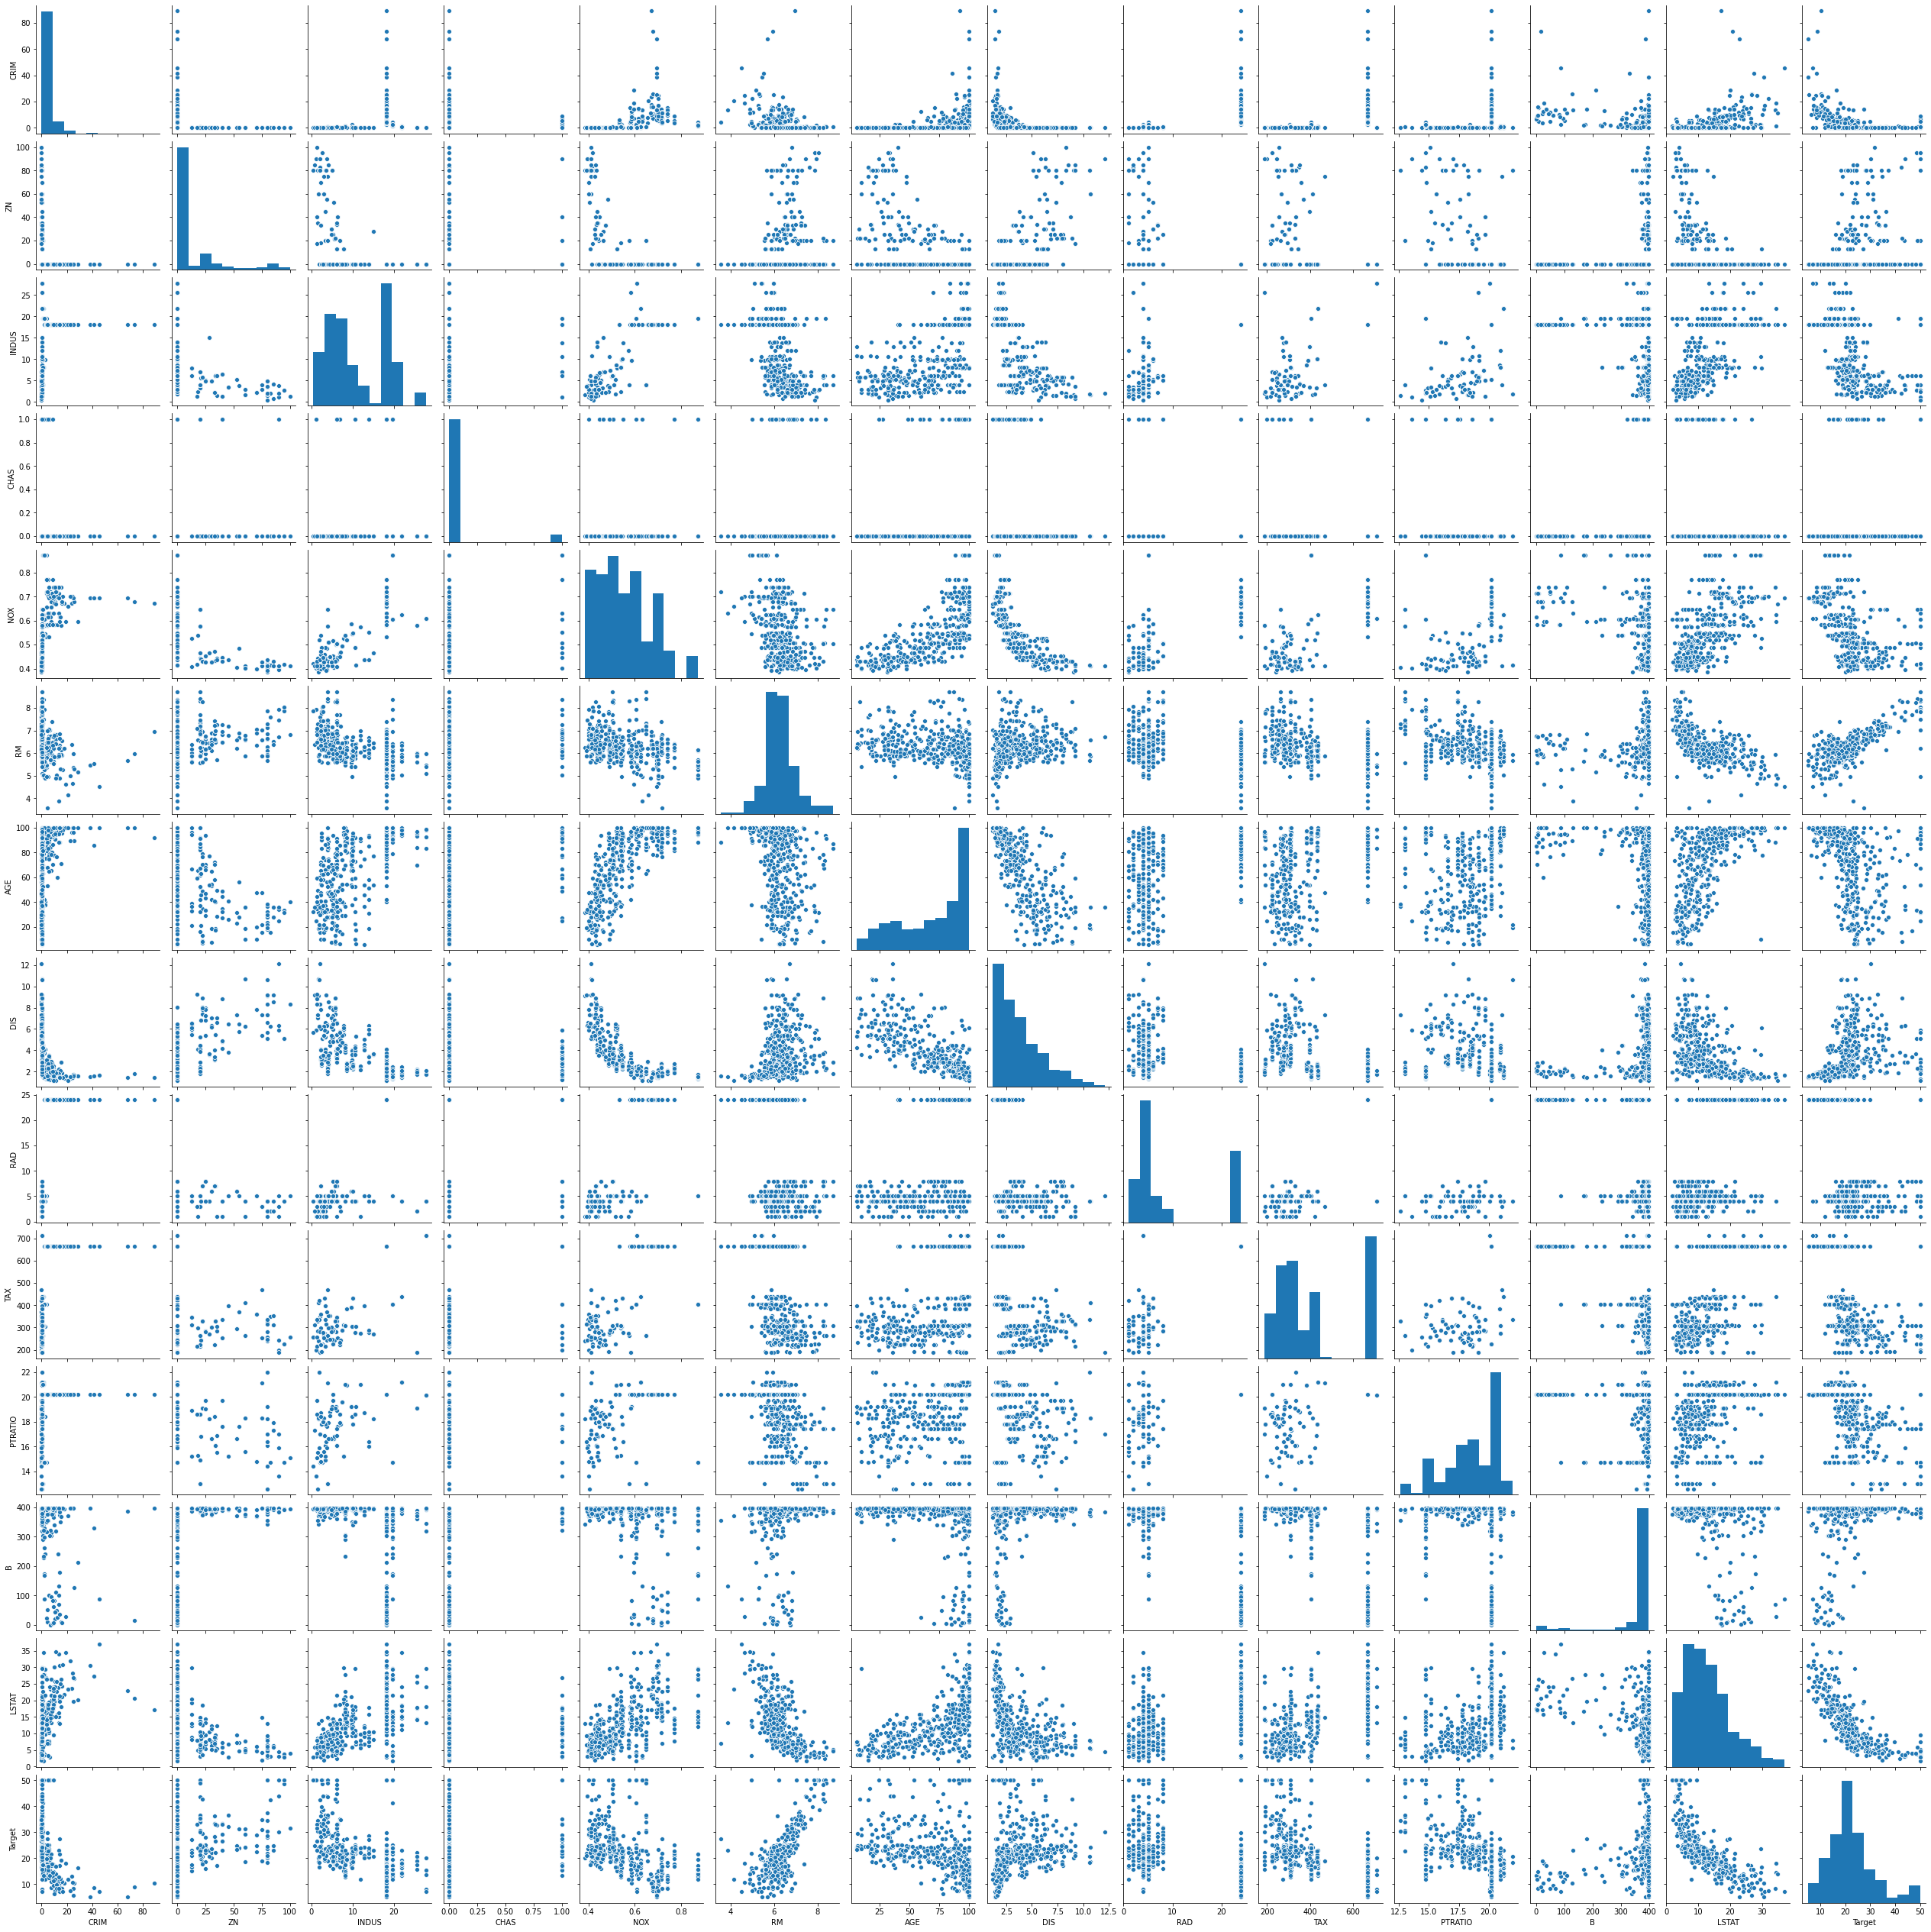

In [ ]:
sns.pairplot(pd.concat([X_train, y_train], axis=1))
plt.show()

- From **Distributions and Correlations** (plots above), we can easily see that **only RM (average number of rooms per dwelling)** among all explanatory variables **has a gaussian distribution**.
- The scatter plots tell us that **RM, LSTAT, INDUS, and PTRATIO can be good regressors**
- **ZN** doesn't seem so useful as it is. We can try to convert it to binary later and see if it get

In [ ]:
# adding a binary variable for 'ZN'
X_train['ZN_bi'] = (data['ZN']/data['ZN']).fillna(0.0)
X_test['ZN_bi'] = (data['ZN']/data['ZN']).fillna(0.0)

In [ ]:
X_train.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,ZN_bi
count,404.000000,404.000000,404.000000,404.000000,404.00000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.556133,11.163366,11.190347,0.056931,0.55548,6.281676,68.974505,3.786204,9.509901,408.445545,18.463861,357.209084,12.825347,0.264851
std,8.788241,22.973132,6.949621,0.231997,0.11639,0.704875,28.021271,2.138012,8.661394,168.499919,2.148906,91.677481,7.127718,0.441801
min,0.006320,0.000000,0.460000,0.000000,0.38500,3.561000,6.000000,1.169100,1.000000,187.000000,12.600000,0.320000,1.730000,0.000000
25%,0.081960,0.000000,5.130000,0.000000,0.45200,5.887750,45.325000,2.097050,4.000000,279.000000,17.400000,376.092500,7.187500,0.000000
50%,0.252775,0.000000,9.690000,0.000000,0.53800,6.201500,77.700000,3.100900,5.000000,330.000000,19.050000,391.955000,11.490000,0.000000
75%,3.681942,12.500000,18.100000,0.000000,0.62400,6.616500,94.100000,5.117025,24.000000,666.000000,20.200000,396.157500,17.127500,1.000000
max,88.976200,100.000000,27.740000,1.000000,0.87100,8.725000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,36.980000,1.000000


## **Look for outliers** 

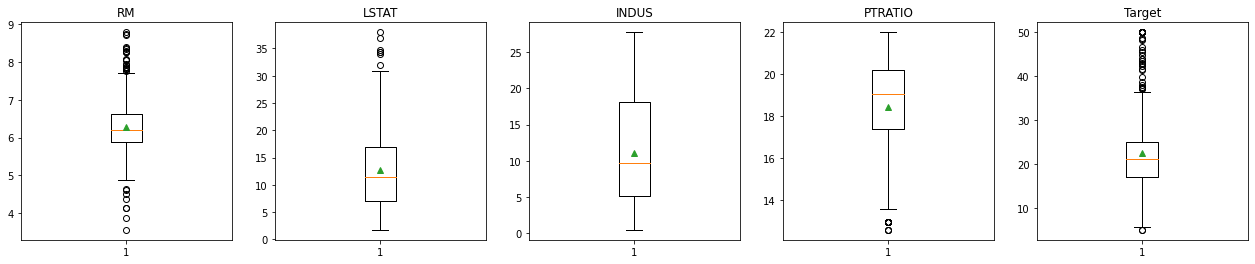

In [ ]:
fig, axs = plt.subplots(1,5, figsize=(22, 4))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
for e, i in enumerate(['RM','LSTAT','INDUS','PTRATIO','Target']):
  axs[e].boxplot(x=data[i], vert=True, showmeans=True)
  axs[e].set_title(i)

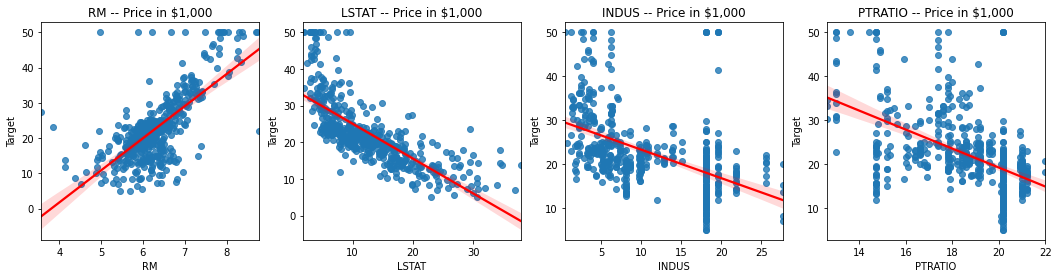

In [ ]:
fig, axs = plt.subplots(1,4, figsize=(4*4.5, 4))
fig.subplots_adjust(hspace = .2, wspace=.2)
# axs = axs.ravel()
for e, i in enumerate(['RM','LSTAT','INDUS','PTRATIO']):
  sns.regplot(x=data[i], y=data['Target'], ax=axs[e], line_kws={'color':'red'})
  axs[e].set_title(str(i+' -- '+'Price in $1,000'))

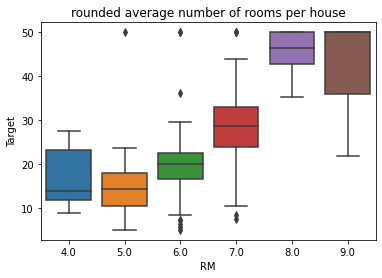

In [ ]:
sns.boxplot(data['RM'].round(), data['Target'])
plt.title('rounded average number of rooms per house', size=12)
plt.show()

There're houses with rooms between around 5 and 7 that cost as expensive as the ones with 9 rooms.

In [ ]:
mask1 = (data['RM'] >= 4.5) & (data['RM'] <= 7.5 )      # rooms between 4.5 and 7.5
mask2 = (data['Target'] >= 45)                          # price > $45,000
# data[mask1 & mask2].sort_values(by=['Target'], ascending=False)

In [ ]:
mask3 = (data['INDUS'] >= 15) & (data['Target'] >= 40)
# data[mask3]

In [ ]:
mask4 = (data['PTRATIO'] >= 18) & (data['Target'] >= 45)
# data[mask4]

In [ ]:
# data[mask1 & mask2 | mask3 | mask4]

## **Labeling and Visualizing Outliers**

In [ ]:
# create another variable to label potential outliers

"""label previously detected outliers"""
new_row = np.zeros((len(data)))
for i in data[mask1 & mask2 | mask3 | mask4].index:
  new_row[i] += 1

"""label outliers by multivariate method (DBSCAN)"""
d_scaled = StandardScaler().fit_transform(data[data.columns[:13]].values)

db = DBSCAN(eps=3.75, min_samples=10).fit(d_scaled)
labels = db.labels_
for e, i in enumerate(labels):
  if i == -1 and new_row[e] != 1:
    new_row[e] += 2

data['outliers?'] = new_row

In [ ]:
_db_result = np.unique(data['outliers?'], return_counts=True)
print(f" good data                   :{_db_result[1][0]}")
print(f" manually detected           :{_db_result[1][1]}")
print(f" DBSCAN (not overlapped)     :{_db_result[1][2]}")

 good data                   :488
 manually detected           :10
 DBSCAN (not overlapped)     :8


Red: manual	Purple: DBSCAN


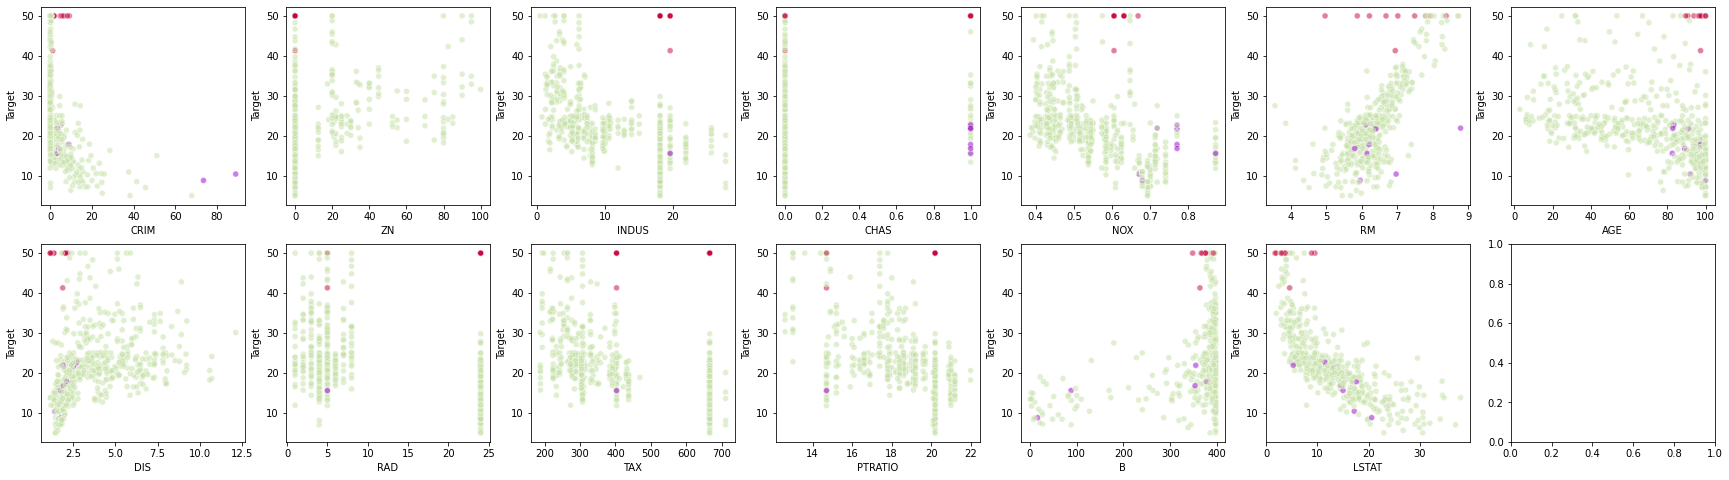

In [ ]:
fig, axs = plt.subplots(2,7, figsize=(30, 8))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()

colors = ["#C5E1A5", "#C70039", "#9900CC"]

sns.set_palette(sns.color_palette(colors))

print(f"Red: manual\tPurple: DBSCAN")
for e, i in enumerate(data.columns[:13]):
  sns.scatterplot(x=data[i], y=data['Target'], ax=axs[e], hue=data['outliers?'], alpha=0.5, legend=False,
                  palette=colors)

Overall, the datapoints labeled by DBSCAN don't really look like outliers.
In contrast, the datapoints we manually labeled can be clearly seen as outliers.
A better practice can be creating a function to label outliers automatically using Interquartile Range (IQR).

## **Feature Importance with XGBoost**

When working on a dataset with hundreds or thousands of variables, observing or processing each variables at a time is not ideal. In a case like this, we want to know what features (variables) are important, and XGBoost has a function to calculate that.

In [ ]:
"""receives two arguments
   1. model name
   2. boolean:   True  => normalized
                 False => non-normalized """
def group_gain_weight(model, normalize=False):
  x1 = list(XGBRegressor.get_booster(model).get_score(importance_type='gain').keys())
  x2 = list(XGBRegressor.get_booster(model).get_score(importance_type='weight').keys())
  X = np.concatenate((np.asarray(x1), np.asarray(x2)))

  y1 = list(XGBRegressor.get_booster(model).get_score(importance_type='gain').values())   # Relative Contribution to prediction
  y2 = list(XGBRegressor.get_booster(model).get_score(importance_type='weight').values()) # Total occurance from all splits and all trees
  if normalize:
    y1 = (y1-np.min(y1))/(np.max(y1)-np.min(y1))
    y2 = (y2-np.min(y2))/(np.max(y2)-np.min(y2))

  Y = np.concatenate((np.asarray(y1), np.asarray(y2)))

  hue = np.ravel([['gain']*len(x1), ['weight']*len(x2)])

  data = pd.DataFrame({'feat_name': X,
                       'scores': Y,
                       'metrics': hue})
  
  viz = sns.barplot(x='feat_name', y='scores', hue='metrics', data=data, dodge=True)
  viz.set_xticklabels(viz.get_xticklabels(), rotation=45, horizontalalignment='right')

[08:01:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


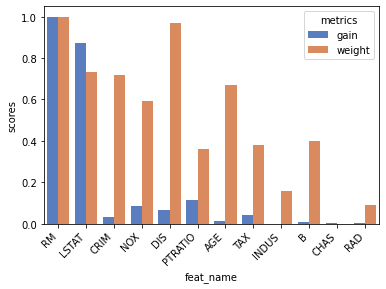

In [ ]:
sns.set_palette(sns.color_palette('muted'))

XGBR = XGBRegressor()
XGBR.fit(X_train, y_train)
group_gain_weight(XGBR, True)

In [ ]:
def get_top_feats(model, n_feats=3):
  return list(pd.Series(XGBRegressor.get_booster(model)\
                          .get_score(importance_type='gain'))\
                .sort_values(ascending=False)[:n_feats]\
                .keys())

In [ ]:
get_top_feats(XGBR, 3)

['RM', 'LSTAT', 'PTRATIO']

XGBoost offers several metrics and **gain** is considered one of the most reliable/important indicators in XGBoost as it tells us what feature is important for generating prediction. (I included **weight** just to compare the scores from different metrics.)

## **Model selection**

**Baseline model** 

In [ ]:
print(f"{len(X_train)}\n{len(y_train)}")

404
404


In [ ]:
def std_scale(dat):
  return StandardScaler().fit_transform(dat)

In [ ]:
# baseline == mean
base_mean = DummyRegressor(strategy='mean')
base_mean.fit(std_scale(X_train), y_train)
y_mean = base_mean.predict(X_train)

In [ ]:
print('MSE:', round(metrics.mean_squared_error(y_train, y_mean), 4))

MSE: 84.7207


**Candidate models**

In [ ]:
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.linear_model import LinearRegression #, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor

def get_models():
  models, names = [], []
  # Base line
  models.append(DummyRegressor(strategy='mean'))
  names.append('Base')
  # Linear Regression
  models.append(LinearRegression())
  names.append('LR  ')
  # Decision Tree
  models.append(DecisionTreeRegressor(max_depth=4, random_state=123))
  names.append('DT  ')
  # Random Forest
  models.append(RandomForestRegressor(n_estimators=64, max_depth=4, random_state=123))
  names.append('RF  ')
  # XGBoost
  models.append(XGBRegressor(n_estimators=64,
                             max_depth=4,
                             learning_rate=0.075,
                             early_stopping_rounds=10,
                             random_state=123))
  names.append('XGB ')
  # Multi-layer Perceptron
  models.append(MLPRegressor(hidden_layer_sizes=(12,),
                             solver='sgd',
                             learning_rate='adaptive',
                             random_state=123))
  names.append('MLP ')
  return models, names

def evaluate_model(X, y, model, score='neg_mean_squared_error'):
  cv = RepeatedKFold(random_state=123) # Default: n_fold=5, n_repeats=10
  scores = cross_val_score(model, X, y, scoring=score, cv=cv, n_jobs=-1)
  return scores*-1

### **Using the best 3 features from feature importance**

In [ ]:
models, names = get_models()
results = []
selected_feats = get_top_feats(XGBR, 3) # get 3 most important features
X = std_scale(X_train[selected_feats])

print(f"\t\tMSE")
for i in range(len(models)):
  scores = evaluate_model(X, y_train, models[i])
  results.append(scores)
  print(f"{names[i]}: Mean: {np.round(np.mean(scores),3)} Std: {np.round(np.std(scores),3)}")

		MSE
Base: Mean: 85.145 Std: 15.193
LR  : Mean: 25.668 Std: 7.381
DT  : Mean: 21.416 Std: 7.222
RF  : Mean: 16.462 Std: 6.866
XGB : Mean: 16.126 Std: 6.854
MLP : Mean: 15.93 Std: 6.601


### **Using the best 4 features from feature importance**

In [ ]:
models, names = get_models()
results = []
selected_feats = get_top_feats(XGBR, 4) # get 4 most important features
X = std_scale(X_train[selected_feats])

print(f"\t\tMSE")
for i in range(len(models)):
  scores = evaluate_model(X, y_train, models[i])
  results.append(scores)
  print(f"{names[i]}: Mean: {np.round(np.mean(scores),3)} Std: {np.round(np.std(scores),3)}")

		MSE
Base: Mean: 85.145 Std: 15.193
LR  : Mean: 25.983 Std: 7.633
DT  : Mean: 22.545 Std: 9.427
RF  : Mean: 14.954 Std: 6.339
XGB : Mean: 13.237 Std: 5.685
MLP : Mean: 15.889 Std: 6.468


In [ ]:
def calculate_error_scores(y_true, y_pred, score='mse'):
  if score == 'mse':
    error = round(metrics.mean_squared_error(y_true, y_pred), 4)
  elif score == 'mae':
    error = round(metrics.mean_absolute_error(y_true, y_pred), 4)
  elif score == 'rmse':
    error = round((metrics.mean_squared_error(y_true, y_pred))**0.5, 4)
  elif score == 'rmsle':
    error = round((metrics.mean_squared_log_error(y_true, y_pred))**0.5, 4)
  else:
    return 'metric not available'
  return error

models, names = get_models()

X_train_ = std_scale(X_train[selected_feats].values)
X_test_ = std_scale(X_test[selected_feats].values)

print(f"\tMSE")
for i in range(len(models)):
  models[i].fit(X_train_, y_train)
  y_pred = models[i].predict(X_test_)
  print(f"{names[i]}: {calculate_error_scores(y_test, y_pred, score='mse')}")

	MSE
Base: 83.3505
LR  : 37.6806
DT  : 28.412
RF  : 26.988
[08:01:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB : 21.7891
MLP : 31.239


We can choose one model that we think the most suitable for the task at this point. Nontheless, combining the predictive power from several models (or **stacking ensemble model** as a more appropriate name) can give us a more robust prediction.

**Scores without manually detected outliers**

In [ ]:
X_train_no_outliers = std_scale(X_train.drop(list(X_train[mask1 & mask2 & mask3 & mask4].index))[selected_feats].values)
y_train_no_outliers = y_train.drop(list(X_train[mask1 & mask2 & mask3 & mask4].index)).values
X_test_ = std_scale(X_test[selected_feats].values)

print(f"\tMSE")
for i in range(len(models)):
  models[i].fit(X_train_no_outliers, y_train_no_outliers)
  y_pred = models[i].predict(X_test_)
  print(f"{names[i]}: {calculate_error_scores(y_test, y_pred, score='mse')}")

	MSE
Base: 83.7173
LR  : 37.9417
DT  : 25.8275
RF  : 28.4226
[08:01:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGB : 25.9
MLP : 31.5162


## **Trying all together**

In [ ]:
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.dummy import DummyRegressor
from sklearn import metrics

from sklearn.model_selection import RepeatedKFold, cross_val_score
from xgboost import *

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def load_data(dat):
  feat_names = list(dat.feature_names)
  feat_names.extend(['PRICE'])
  # create a dataframe and update col names
  dat = pd.DataFrame(data = np.hstack((dat.data, 
                                       dat.target[:, None]
                                       )),
                     columns = feat_names
                     )
  return dat


""" Standardize data (numeric)
"""
def std_scale(dat):
  return StandardScaler().fit_transform(dat)


""" receives 3 arguments;
    1. model
    2. normalize (boolean, True/False) 
    3. metric (str) e.g. 'gain', 'weight'
"""
def plot_feat_importance(model, normalize_score=False, metric='gain'):
  x = list(XGBRegressor.get_booster(model).get_score(importance_type=metric).keys())
  y = list(XGBRegressor.get_booster(model).get_score(importance_type=metric).values())   # Relative Contribution to prediction
  if normalize_score:
    y1 = (y1-np.min(y1))/(np.max(y1)-np.min(y1))

  data = pd.DataFrame({'feat_name': x,
                       'scores': y,})
  
  viz = sns.barplot(x='feat_name', y='scores',
                    data=data,
                    dodge=True)
  viz.set_xticklabels(viz.get_xticklabels(),
                      rotation=45,
                      horizontalalignment='right')


""" receives 3 arguments; 
    1. model 
    2. number of output from sorted feature importance (default=3)
    3. metric (default=gain)
    returns a list of sorted features from the most to least important.
"""
def get_feature_importance(model, n_feats=3, metric='gain'):
  return list(pd.Series(XGBRegressor.
                        get_booster(model)\
                        .get_score(importance_type=metric)
                        )\
              .sort_values(ascending=False)[:n_feats]\
              .keys()
              )


""" receives 4 arguments;
    1. X (predictor)
    2. y (target)
    3. model
    4. score (str) (from scikit-learn)
"""
def evaluate_model(X, y, model, score='neg_mean_squared_error'):
  cv = RepeatedKFold(random_state=123) # Default: n_fold=5, n_repeats=10
  scores = cross_val_score(model, X, y, scoring=score, cv=cv, n_jobs=-1)
  return scores*-1

In [ ]:
data = load_data(load_boston())
print(f"missing data: {data.any().isnull().sum()}")
print(f"duplicates  : {len(data) != len(data.drop_duplicates())}")

X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,:-1],
                                                    data.iloc[:,-1],
                                                    test_size=0.20,
                                                    random_state=123
                                                    )
print("x_train: ",X_train.shape)
print("y_train: ",y_train.shape)
print("x_test:  ",X_test.shape)
print("y_test:  ",y_test.shape)

missing data: 0
duplicates  : False
x_train:  (404, 13)
y_train:  (404,)
x_test:   (102, 13)
y_test:   (102,)


[08:01:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


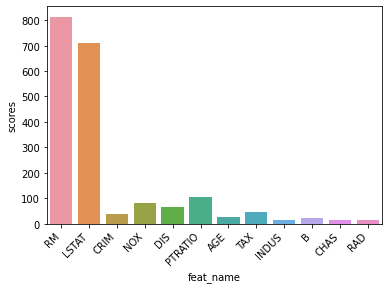

In [ ]:
model_feature_importance = XGBRegressor()
model_feature_importance.fit(X_train, y_train)
plot_feat_importance(model_feature_importance)

In [ ]:
get_feature_importance(model_feature_importance, n_feats=4)

['RM', 'LSTAT', 'PTRATIO', 'NOX']

In [ ]:
X = std_scale(X_train[get_feature_importance(model_feature_importance, n_feats=4)].values)
y = y_train.values

In [ ]:
# set param for grid search
n_estimators = np.arange(10, 110, 10)
max_depth = np.arange(2, 11, 1)
lr = np.linspace(0.05, 0.095, 10)

def grid_search():
  results = []
  progress = 0

  for i_est in n_estimators:
    for i_depth in max_depth:
      for i_lr in lr:
        model = XGBRegressor(n_estimators=i_est,
                             max_depth = i_depth,
                             learning_rate = i_lr,
                             random_state = 123
                             )
        scores = evaluate_model(X, y, model)
        results.append([np.mean(scores),
                        'n_estimator: '+str(i_est),
                        'i_depth: '+str(i_depth),
                        'i_lr: '+str(i_lr)]
                       )
        progress += 1
        print('\rProgress: ',
              str(progress)+"/"+ str(len(n_estimators)*len(max_depth)*len(lr)),
              end=''
              )
        
  return results

In [ ]:
search_result = grid_search()

Progress:  900/900

In [ ]:
sorted(search_result)[:5]

[[12.594041213766817, 'n_estimator: 100', 'i_depth: 4', 'i_lr: 0.08'],
 [12.61640646676175, 'n_estimator: 100', 'i_depth: 4', 'i_lr: 0.085'],
 [12.640610978027336, 'n_estimator: 90', 'i_depth: 4', 'i_lr: 0.08'],
 [12.673372109140415, 'n_estimator: 90', 'i_depth: 4', 'i_lr: 0.085'],
 [12.708027299787158, 'n_estimator: 100', 'i_depth: 3', 'i_lr: 0.09']]

In [ ]:
model = XGBRegressor(n_estimators=100,
                     max_depth=4,
                     learning_rate=0.08,
                     random_state=123)
model.fit(X, y)

X_test_scaled = std_scale(X_test[get_feature_importance(model_feature_importance, n_feats=4)].values)
y_pred = model.predict(X_test_scaled)

[08:52:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [ ]:
np.mean((y_test - y_pred)**2)

23.014390275400636

In [ ]:
# predict again with better hyperparameters
model = XGBRegressor(n_estimators=60,
                             max_depth=4,
                             learning_rate=0.078,
                             random_state=123)

model.fit(X, y)

X_test_scaled = std_scale(X_test[get_feature_importance(model_feature_importance, n_feats=4)].values)
y_pred = model.predict(X_test_scaled)
np.mean((y_test - y_pred)**2)

[08:57:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


21.39879646314284

It is possible that we miss the opportunity to reach maximum accuracy because each step taken are still too rough that the grid search skips the parameters for our ideal accuracy. 
In this case, I usually start a grid search with wide steps and search again with smaller steps using information from the previous search. 

E.g. 
  - Grid Search 1: [1, 2, 3, 4, 5]
    - if best accuracy appears when the parameter = 2
  - Grid search 2: [1.0, 1.5, 2.0, 2.5, 3.0]
    - if best accuracy appears when the parameter = 2.5
  - Repeat until reaching optimum accuracy

### Note:
this method is not a good practice when training takes a lot of time and resources. Better methods might be Bayesian Optimization or Stacking Ensemble depending on the size of your data and model.